In [1]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tqdm import tqdm

tf.random.set_seed(1234) 

2022-04-14 08:44:22.454327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-14 08:44:22.454356: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATA_DIR = "/home/andrew/Trennen/data/off"
mesh = trimesh.load(os.path.join(DATA_DIR, "dex/train/25273.off"))
mesh.show()

/home/andrew/.local/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


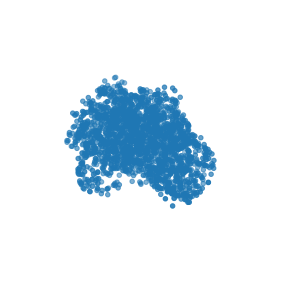

In [3]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [4]:
def parse_dataset(num_points=2048):
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    print(folders)

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files  = glob.glob(os.path.join(folder, "test/*" ))

        for f in tqdm(train_files):
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in tqdm(test_files):
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    train_points, train_labels = unison_shuffled_copies(np.array(train_points), np.array(train_labels))
    test_points,  test_labels  = unison_shuffled_copies(np.array(test_points),  np.array(test_labels) )
    
    return train_points, test_points, train_labels, test_labels, class_map

In [5]:
NUM_POINTS = 2048
NUM_CLASSES = 2
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

['/home/andrew/Trennen/data/off/lev', '/home/andrew/Trennen/data/off/dex']
processing class: lev


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1820/1820 [13:46<00:00,  2.20it/s]


processing class: dex


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3190/3190 [22:53<00:00,  2.32it/s]


In [6]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

2022-04-14 11:47:53.785873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-14 11:47:53.786140: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-14 11:47:53.787207: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (andrew-IdeaPad-3-15ALC6): /proc/driver/nvidia/version does not exist
2022-04-14 11:47:53.800290: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 11:47:53.809811: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 982

In [7]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [8]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [9]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [10]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

 activation_9 (Activation)      (None, 2048, 512)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 512)         0           ['activation_9[0][0]']           
 MaxPooling1D)                                                                                    
                                                                                                  
 dense_3 (Dense)                (None, 256)          131328      ['global_max_pooling1d_1[0][0]'] 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 256)         1024        ['dense_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activatio

In [11]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

2022-04-14 11:47:55.086093: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 982794240 exceeds 10% of free system memory.
2022-04-14 11:47:56.009369: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 982794240 exceeds 10% of free system memory.


Epoch 1/20


2022-04-14 11:48:00.556355: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


625/625 [==============================] - 1961s 3s/step - loss: 1.8222 - sparse_categorical_accuracy: 0.6133 - val_loss: 2.1357 - val_sparse_categorical_accuracy: 0.6363
Epoch 2/20
625/625 [==============================] - 1944s 3s/step - loss: 1.7378 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.7344 - val_sparse_categorical_accuracy: 0.6367
Epoch 3/20
625/625 [==============================] - 1933s 3s/step - loss: 1.7270 - sparse_categorical_accuracy: 0.6341 - val_loss: 1.7287 - val_sparse_categorical_accuracy: 0.6367
Epoch 4/20
625/625 [==============================] - 1917s 3s/step - loss: 1.7228 - sparse_categorical_accuracy: 0.6335 - val_loss: 1.7699 - val_sparse_categorical_accuracy: 0.6367
Epoch 5/20
625/625 [==============================] - 1948s 3s/step - loss: 1.7209 - sparse_categorical_accuracy: 0.6340 - val_loss: 1.8670 - val_sparse_categorical_accuracy: 0.6281
Epoch 6/20
625/625 [==============================] - 1946s 3s/step - loss: 1.7199 - sparse_categoric

KeyboardInterrupt: 

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()